# **Semantic Segmentation of Aerial Imagery**


## Setup


### Imports


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install -q -U albumentations

In [ ]:
import os
import cv2
import math
import random
import shutil
import numpy as np
import pandas as pd
import albumentations as A

from IPython.display import clear_output
from random import randint
from glob import glob
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
)

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.metrics import Recall, Precision

from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    GlobalAveragePooling2D,
    Lambda,
    Reshape,
    Dropout,
    AveragePooling2D,
)
from tensorflow.keras.layers import (
    BatchNormalization,
    Activation,
    MaxPooling2D,
    Conv2DTranspose,
    concatenate,
    UpSampling2D,
    multiply,
    add,
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)

clear_output()

### Kaggle Dataset API Download


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json # Change the file permissions to read/write to the owner only

In [ ]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

 84% 25.0M/29.6M [00:00<00:00, 91.5MB/s]
100% 29.6M/29.6M [00:00<00:00, 91.2MB/s]


In [ ]:
!mkdir /content/semantic-segmentation-of-aerial-imagery
!unzip /content/semantic-segmentation-of-aerial-imagery.zip -d /content/semantic-segmentation-of-aerial-imagery
!rm -rf /content/semantic-segmentation-of-aerial-imagery.zip
clear_output()

## Helper Functions


In [ ]:
def patch(src_img_path, patch_size, return_coord=True, return_patchs=True):
    src_img_name, src_img_ext = src_img_path.split("/")[-1].split(".")

    src_img = cv2.cvtColor(cv2.imread(src_img_path), cv2.COLOR_BGR2RGB)
    h, w = src_img.shape[:-1]
    row_range = math.ceil(h / patch_size)
    clmn_range = math.ceil(w / patch_size)

    patchs = []
    patch_coords = []

    for r in range(row_range):
        if (r + 1) * patch_size <= h:
            for c in range(clmn_range):
                if (c + 1) * patch_size <= w:
                    patch = src_img[
                        r * patch_size : (r + 1) * patch_size,
                        c * patch_size : (c + 1) * patch_size,
                    ]
                    patchs.append(patch)
                    patch_coords.append(
                        {
                            "file_path": src_img_path,
                            "xmin": c * patch_size,
                            "xmax": (c + 1) * patch_size,
                            "ymin": r * patch_size,
                            "ymax": (r + 1) * patch_size,
                        }
                    )
                else:
                    patch = src_img[r * patch_size : (r + 1) * patch_size, -patch_size:]
                    patchs.append(patch)

                    patch_coords.append(
                        {
                            "file_path": src_img_path,
                            "xmin": w - patch_size,
                            "xmax": w,
                            "ymin": r * patch_size,
                            "ymax": (r + 1) * patch_size,
                        }
                    )
        else:
            for c in range(clmn_range):
                if (c + 1) * patch_size <= w:
                    patch = src_img[-patch_size:, c * patch_size : (c + 1) * patch_size]
                    patchs.append(patch)
                    patch_coords.append(
                        {
                            "file_path": src_img_path,
                            "xmin": c * patch_size,
                            "xmax": (c + 1) * patch_size,
                            "ymin": h - patch_size,
                            "ymax": h,
                        }
                    )
                else:
                    patch = src_img[-patch_size:, -patch_size:]
                    patchs.append(patch)
                    patch_coords.append(
                        {
                            "file_path": src_img_path,
                            "xmin": w - patch_size,
                            "xmax": w,
                            "ymin": h - patch_size,
                            "ymax": h,
                        }
                    )
    if return_coord:
        if return_patchs:
            return np.array(patchs), patch_coords
        return patch_coords
    return np.array(patchs)

In [ ]:
def unpatch(patchs, patch_coord, img_shape):
    h, w, c = img_shape
    stitched_img = np.zeros((h, w, c), dtype="uint8")

    for patch, coord in zip(patchs, patch_coord):
        _, xmin, xmax, ymin, ymax = coord.values()
        stitched_img[ymin:ymax, xmin:xmax] = patch
    return stitched_img

In [ ]:
"""
________________________________________________________________________

Classes                 HEX code    RGB Values        Sparse Label
________________________________________________________________________

Water                   #50E3C2    (226, 169, 41)     0
Land (unpaved area)     #F5A623    (132, 41, 246)     1
Road                    #DE597F    (110, 193, 228)     2
Building                #D0021B    (60, 16, 152)       3
Vegetation              #417505    (254, 221, 58)      4
Unlabeled               #9B9B9B    (155, 155, 155)    5
___________________________________________________________________

"""

In [ ]:
mask_rgb_values = {
    "Water": (226, 169, 41),
    "Land (unpaved area)": (132, 41, 246),
    "Road": (110, 193, 228),
    "Building": (60, 16, 152),
    "Vegetation": (254, 221, 58),
    "Unlabeled": (155, 155, 155),
}


def encode_categorical(mask, num_classes=6):
    cat_encoded = np.zeros(shape=(*mask.shape[:-1], num_classes), dtype="float32")
    for i, value in enumerate(mask_rgb_values.values()):
        conditions = np.where(mask == value, 1, 0)  # (256, 256, 3)
        conditions = np.prod(conditions, axis=-1).astype("bool")  # (256, 256)
        cat_encoded[conditions, i] = 1.0
    return cat_encoded


def decode_prediction(pred, num_classes=6):
    argmax_idx = np.array([np.argmax(x) for x in pred.reshape((-1, num_classes))])
    argmax_idx = argmax_idx.reshape(pred.shape[:-1])

    decoded_mask = np.zeros(shape=(*pred.shape[:-1], 3), dtype="uint8")

    for i, value in enumerate(mask_rgb_values.values()):
        decoded_mask[argmax_idx == i] = value
    return decoded_mask

## Custom Metrics and Losses


In [ ]:
def tversky(y_true, y_pred, smooth=1.0, alpha=0.7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    tp = K.sum(y_true_f * y_pred_f)
    fn = K.sum(tp * (1 - y_pred_f))
    fp = K.sum((1 - y_true_f) * y_pred_f)
    score = (tp + smooth) / (tp + alpha * fn + (1 - alpha) * fp + smooth)
    return score


def tversky_loss(y_true, y_pred, smooth=1.0, alpha=0.7):
    loss = 1 - tversky(y_true, y_pred, smooth, alpha)
    return loss


def focal_tversky_loss(y_true, y_pred, smooth=1.0, alpha=0.7, gamma=0.75):
    loss = tversky_loss(y_true, y_pred, smooth=1.0, alpha=0.7)
    loss = K.pow(loss, gamma)
    return loss


def CCE_focal_tversky_loss(y_true, y_pred, smooth=1.0, alpha=0.7, gamma=0.75):
    loss = focal_tversky_loss(
        y_true, y_pred, smooth, alpha, gamma
    ) + K.categorical_crossentropy(y_true, y_pred)
    return loss

In [ ]:
class FocalTverskyLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1.0, alpha=0.7, gamma=0.75, name="focal_tversky_loss"):
        super().__init__(name=name)
        self.smooth = smooth
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        return focal_tversky_loss(
            y_true=y_true,
            y_pred=y_pred,
            smooth=self.smooth,
            alpha=self.alpha,
            gamma=self.gamma,
        )


class CombinedLoss(tf.keras.losses.Loss):
    def __init__(
        self, smooth=1.0, alpha=0.7, gamma=0.75, name="CCE_focal_tversky_loss"
    ):
        super().__init__(name=name)
        self.smooth = smooth
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        return CCE_focal_tversky_loss(
            y_true, y_pred, smooth=self.smooth, alpha=self.alpha, gamma=self.gamma
        )

In [ ]:
class DiceCoefficient(tf.keras.metrics.Metric):
    def __init__(self, name="dice_coefficient", **kwargs):
        super(DiceCoefficient, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(
            name="tp", initializer=tf.zeros_initializer()
        )
        self.false_positives = self.add_weight(
            name="fp", initializer=tf.zeros_initializer()
        )
        self.false_negatives = self.add_weight(
            name="fn", initializer=tf.zeros_initializer()
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.round(y_pred), tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred)
        self.true_positives.assign_add(intersection)
        self.false_positives.assign_add(tf.reduce_sum(y_pred) - intersection)
        self.false_negatives.assign_add(tf.reduce_sum(y_true) - intersection)

    def result(self):
        numerator = 2 * self.true_positives
        denominator = (
            2 * self.true_positives + self.false_positives + self.false_negatives
        )
        return numerator / denominator

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [ ]:
class IoUMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="iou", **kwargs):
        super(IoUMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.intersection = self.add_weight(name="intersection", initializer="zeros")
        self.union = self.add_weight(name="union", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert class indices to one-hot tensors
        y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.num_classes)
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=self.num_classes)

        intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
        union = tf.reduce_sum(y_true + y_pred, axis=[0, 1, 2]) - intersection

        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        iou = tf.reduce_mean(tf.math.divide_no_nan(self.intersection, self.union))
        return iou

    def reset_states(self):
        self.intersection.assign(0)
        self.union.assign(0)

In [ ]:
# class IoUMetric(tf.keras.metrics.Metric):
#     def __init__(self, name='iou', **kwargs):
#         super(IoUMetric, self).__init__(name=name, **kwargs)
#         self.intersection = self.add_weight(name='intersection', initializer='zeros')
#         self.union = self.add_weight(name='union', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.cast(y_true, dtype=tf.bool)
#         y_pred = tf.cast(y_pred, dtype=tf.bool)

#         intersection = tf.reduce_sum(tf.cast(y_true & y_pred, dtype=tf.float32))
#         union = tf.reduce_sum(tf.cast(y_true | y_pred, dtype=tf.float32))

#         self.intersection.assign_add(intersection)
#         self.union.assign_add(union)

#     def result(self):
#         return self.intersection / (self.union + tf.keras.backend.epsilon())

#     def reset_state(self):
#         self.intersection.assign(0)
#         self.union.assign(0)

## Custom Data Generator


In [ ]:
# Custom Data Generator
class ImageDataGenerator(Sequence):
    def __init__(
        self,
        img_paths,
        mask_paths,
        patch_size,
        batch_size,
        augment,
        num_classes=6,
        shuffle=False,
    ):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.augment = augment
        self.df = self._get_dataframe()
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _get_dataframe(self):
        df = pd.DataFrame(
            columns=["img_path", "mask_path", "xmin", "xmax", "ymin", "ymax"]
        )
        for img_path, mask_path in zip(self.img_paths, self.mask_paths):
            patch_coords = patch(
                src_img_path=img_path,
                patch_size=self.patch_size,
                return_coord=True,
                return_patchs=False,
            )
            for coord in patch_coords:
                img_path, xmin, xmax, ymin, ymax = coord.values()
                df.loc[len(df.index)] = img_path, mask_path, xmin, xmax, ymin, ymax
        return df

    def __getitem__(self, index):
        batch_indexes = self.indexes[
            index * self.batch_size : (index + 1) * self.batch_size
        ]
        batch_df = self.df.iloc[batch_indexes]

        X, y = self.__load_batch(batch_df)
        return X, y

    def __load_batch(self, batch_df):
        batch_img = []
        batch_mask = []

        for _, row in batch_df.iterrows():
            image = cv2.cvtColor(cv2.imread(row["img_path"]), cv2.COLOR_BGR2RGB)
            mask = cv2.cvtColor(cv2.imread(row["mask_path"]), cv2.COLOR_BGR2RGB)

            xmin = row["xmin"]
            xmax = row["xmax"]
            ymin = row["ymin"]
            ymax = row["ymax"]

            image = image[ymin:ymax, xmin:xmax]
            mask = mask[ymin:ymax, xmin:xmax]

            if self.augment:
                transform = A.Compose(
                    [
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                    ]
                )
                augments = transform(image=image, mask=mask)
                image = augments["image"]
                mask = augments["mask"]

            image = image / 255.0
            mask = encode_categorical(mask, num_classes=self.num_classes)

            batch_img.append(image)
            batch_mask.append(mask)
        return np.array(batch_img, dtype="float32"), np.array(
            batch_mask, dtype="float32"
        )

## Data Preparation


In [ ]:
img_paths = glob(
    "/content/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/**/images/*.jpg"
)

# Train-val-test spliting
train_val_img_paths, test_img_paths = train_test_split(
    img_paths, test_size=0.2, random_state=42
)
train_img_paths, val_img_paths = train_test_split(
    train_val_img_paths, test_size=0.2, random_state=42
)

train_mask_paths = [
    path.replace(".jpg", ".png").replace("images", "masks") for path in train_img_paths
]
val_mask_paths = [
    path.replace(".jpg", ".png").replace("images", "masks") for path in val_img_paths
]
test_mask_paths = [
    path.replace(".jpg", ".png").replace("images", "masks") for path in test_img_paths
]

len(train_img_paths), len(val_img_paths), len(test_img_paths)

(45, 12, 15)

## The Model


In [ ]:
# Blocks
def conv_block(input, n_filters, set_batchnorm, dropout):
    x = Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(input)
    if set_batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    if set_batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if dropout > 0:
        x = Dropout(dropout)(x)
    return x


def encoder_block(input, n_filters, set_batchnorm, dropout):
    x = conv_block(input, n_filters, set_batchnorm, dropout)
    p = MaxPooling2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_feature, n_filters, set_batchnorm, dropout):
    x = Conv2DTranspose(n_filters, (2, 2), strides=2, padding="same")(input)
    x = concatenate([x, *skip_feature], axis=-1)
    x = conv_block(x, n_filters, set_batchnorm, dropout)
    return x

In [ ]:
# U-Net
def unet(input_shape, n_classes, n_filters, set_batchnorm, dropout):
    inputs = Input(input_shape)

    conv1, pool1 = encoder_block(inputs, n_filters, set_batchnorm, dropout)
    conv2, pool2 = encoder_block(pool1, n_filters * 2, set_batchnorm, dropout)
    conv3, pool3 = encoder_block(pool2, n_filters * 4, set_batchnorm, dropout)
    conv4, pool4 = encoder_block(pool3, n_filter * 8, set_batchnorm, dropout)
    conv5, pool5 = encoder_block(pool4, n_filters * 16, set_batchnorm, dropout)

    midconv = conv_block(pool5, n_filters * 32, set_batchnorm, dropout)

    upconv1 = decoder_block(midconv, [conv5], n_filters * 16, set_batchnorm, dropout)
    upconv2 = decoder_block(upconv1, [conv4], n_filters * 8, set_batchnorm, dropout)
    upconv3 = decoder_block(upconv2, [conv3], n_filters * 4, set_batchnorm, dropout)
    upconv4 = decoder_block(upconv3, [conv2], n_filters * 2, set_batchnorm, dropout)
    upconv5 = decoder_block(upconv4, [conv1], n_filters, set_batchnorm, dropout)

    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(upconv5)
    model = Model(inputs, outputs, name="unet")
    return model


unet(
    input_shape=(256, 256, 3),
    n_classes=6,
    n_filters=32,
    set_batchnorm=True,
    dropout=0.2,
).summary()

## Model Training


### aerial_segmentation_unet**adam0.0003**batch_24\_\_dice_coef


In [ ]:
_batch_size = 24
train_generator = ImageDataGenerator(
    img_paths=train_img_paths,
    mask_paths=train_mask_paths,
    patch_size=256,
    batch_size=_batch_size,
    augment=True,
    num_classes=6,
    shuffle=True,
)

val_generator = ImageDataGenerator(
    img_paths=val_img_paths,
    mask_paths=val_mask_paths,
    patch_size=256,
    batch_size=_batch_size,
    augment=True,
    num_classes=6,
    shuffle=True,
)

test_generator = ImageDataGenerator(
    img_paths=test_img_paths,
    mask_paths=test_mask_paths,
    patch_size=256,
    batch_size=_batch_size,
    augment=False,
    num_classes=6,
    shuffle=False,
)

In [ ]:
n_epochs = 200
init_lr = 0.0003

model = unet(
    input_shape=(256, 256, 3),
    n_classes=6,
    n_filters=32,
    set_batchnorm=True,
    dropout=0.2,
)

# path assignment
log_name = f"aerial_segmentation_{model.name}__adam{str(init_lr)}__batch_{_batch_size}__dice_coef"
logdir = f"/content/drive/MyDrive/AerialImageSegmentation/Training/TensorboardLogs/{log_name}"
ckptdir = f"/content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/{log_name}"

# callbacks
checkpoint = ModelCheckpoint(
    ckptdir,
    monitor="val_dice_coefficient",
    verbose=1,
    mode="max",
    save_best_only=True,
    save_freq="epoch",
)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(
    monitor="val_dice_coefficient",
    factor=0.95,
    mode="max",
    patience=2,
    verbose=1,
    min_delta=0.0001,
)
earlystop = EarlyStopping(
    monitor="val_dice_coefficient", patience=7, mode="max", min_delta=0.0001
)

opt = tf.keras.optimizers.Adam(learning_rate=init_lr)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy", DiceCoefficient()],
)

print(f"Started Training for {log_name}")
hist = model.fit(
    x=train_generator,
    #  steps_per_epoch=2,
    #  validation_steps=2,
    epochs=n_epochs,
    validation_data=val_generator,
    callbacks=[tensorboard, reduce_lr, checkpoint, earlystop],
)

Started Training for aerial_segmentation_unet__adam0.0003__batch_24__dice_coef
Epoch 1/200
53/53 [==============================] - ETA: 0s - loss: 1.2576 - accuracy: 0.6227 - dice_coefficient: 0.4880
Epoch 1: val_dice_coefficient improved from -inf to 0.16294, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 224s 3s/step - loss: 1.2576 - accuracy: 0.6227 - dice_coefficient: 0.4880 - val_loss: 11.3696 - val_accuracy: 0.2070 - val_dice_coefficient: 0.1629 - lr: 3.0000e-04
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.8565 - accuracy: 0.7771 - dice_coefficient: 0.7381
Epoch 2: val_dice_coefficient improved from 0.16294 to 0.36375, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 169s 3s/step - loss: 0.8565 - accuracy: 0.7771 - dice_coefficient: 0.7381 - val_loss: 1.5856 - val_accuracy: 0.3470 - val_dice_coefficient: 0.3638 - lr: 3.0000e-04
Epoch 3/200
53/53 [==============================] - ETA: 0s - loss: 0.7274 - accuracy: 0.8138 - dice_coefficient: 0.7910
Epoch 3: val_dice_coefficient improved from 0.36375 to 0.37006, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 168s 3s/step - loss: 0.7274 - accuracy: 0.8138 - dice_coefficient: 0.7910 - val_loss: 2.1223 - val_accuracy: 0.3833 - val_dice_coefficient: 0.3701 - lr: 3.0000e-04
Epoch 4/200
53/53 [==============================] - ETA: 0s - loss: 0.7044 - accuracy: 0.8097 - dice_coefficient: 0.7924
Epoch 4: val_dice_coefficient did not improve from 0.37006
53/53 [==============================] - 152s 3s/step - loss: 0.7044 - accuracy: 0.8097 - dice_coefficient: 0.7924 - val_loss: 1.6812 - val_accuracy: 0.3967 - val_dice_coefficient: 0.3663 - lr: 3.0000e-04
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.6353 - accuracy: 0.8267 - dice_coefficient: 0.8137
Epoch 5: val_dice_coefficient improved from 0.37006 to 0.40489, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 163s 3s/step - loss: 0.6353 - accuracy: 0.8267 - dice_coefficient: 0.8137 - val_loss: 1.7510 - val_accuracy: 0.4271 - val_dice_coefficient: 0.4049 - lr: 3.0000e-04
Epoch 6/200
53/53 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.8312 - dice_coefficient: 0.8209
Epoch 6: val_dice_coefficient improved from 0.40489 to 0.52695, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 163s 3s/step - loss: 0.6044 - accuracy: 0.8312 - dice_coefficient: 0.8209 - val_loss: 1.5159 - val_accuracy: 0.5252 - val_dice_coefficient: 0.5269 - lr: 3.0000e-04
Epoch 7/200
53/53 [==============================] - ETA: 0s - loss: 0.5865 - accuracy: 0.8332 - dice_coefficient: 0.8256
Epoch 7: val_dice_coefficient improved from 0.52695 to 0.53870, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 167s 3s/step - loss: 0.5865 - accuracy: 0.8332 - dice_coefficient: 0.8256 - val_loss: 1.4731 - val_accuracy: 0.5320 - val_dice_coefficient: 0.5387 - lr: 3.0000e-04
Epoch 8/200
53/53 [==============================] - ETA: 0s - loss: 0.5589 - accuracy: 0.8371 - dice_coefficient: 0.8292
Epoch 8: val_dice_coefficient did not improve from 0.53870
53/53 [==============================] - 154s 3s/step - loss: 0.5589 - accuracy: 0.8371 - dice_coefficient: 0.8292 - val_loss: 1.6901 - val_accuracy: 0.5038 - val_dice_coefficient: 0.5072 - lr: 3.0000e-04
Epoch 9/200
53/53 [==============================] - ETA: 0s - loss: 0.5367 - accuracy: 0.8418 - dice_coefficient: 0.8359
Epoch 9: val_dice_coefficient improved from 0.53870 to 0.61606, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 172s 3s/step - loss: 0.5367 - accuracy: 0.8418 - dice_coefficient: 0.8359 - val_loss: 1.2770 - val_accuracy: 0.6103 - val_dice_coefficient: 0.6161 - lr: 3.0000e-04
Epoch 10/200
53/53 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.8436 - dice_coefficient: 0.8379
Epoch 10: val_dice_coefficient improved from 0.61606 to 0.64533, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 173s 3s/step - loss: 0.5222 - accuracy: 0.8436 - dice_coefficient: 0.8379 - val_loss: 1.1273 - val_accuracy: 0.6422 - val_dice_coefficient: 0.6453 - lr: 3.0000e-04
Epoch 11/200
53/53 [==============================] - ETA: 0s - loss: 0.5179 - accuracy: 0.8419 - dice_coefficient: 0.8367
Epoch 11: val_dice_coefficient did not improve from 0.64533
53/53 [==============================] - 153s 3s/step - loss: 0.5179 - accuracy: 0.8419 - dice_coefficient: 0.8367 - val_loss: 1.0480 - val_accuracy: 0.6469 - val_dice_coefficient: 0.6451 - lr: 3.0000e-04
Epoch 12/200
53/53 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.8443 - dice_coefficient: 0.8396
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00028500001353677363.

Epoch 12: val_dice_coefficient did not improve from 0.64533
53/53 [==============================] - 152s 3s/step - loss: 0.5077 - accuracy: 0.8443 - dice_coefficient: 0.8396 - val_loss: 1.2123 - val_accur

53/53 [==============================] - 169s 3s/step - loss: 0.4719 - accuracy: 0.8524 - dice_coefficient: 0.8481 - val_loss: 0.9026 - val_accuracy: 0.6536 - val_dice_coefficient: 0.6603 - lr: 2.8500e-04
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.8513 - dice_coefficient: 0.8468
Epoch 15: val_dice_coefficient improved from 0.66029 to 0.70600, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 165s 3s/step - loss: 0.4693 - accuracy: 0.8513 - dice_coefficient: 0.8468 - val_loss: 0.8416 - val_accuracy: 0.7022 - val_dice_coefficient: 0.7060 - lr: 2.8500e-04
Epoch 16/200
53/53 [==============================] - ETA: 0s - loss: 0.4698 - accuracy: 0.8519 - dice_coefficient: 0.8479
Epoch 16: val_dice_coefficient did not improve from 0.70600
53/53 [==============================] - 149s 3s/step - loss: 0.4698 - accuracy: 0.8519 - dice_coefficient: 0.8479 - val_loss: 0.8969 - val_accuracy: 0.6349 - val_dice_coefficient: 0.6462 - lr: 2.8500e-04
Epoch 17/200
53/53 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8572 - dice_coefficient: 0.8529
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002707500156247988.

Epoch 17: val_dice_coefficient did not improve from 0.70600
53/53 [==============================] - 164s 3s/step - loss: 0.4484 - accuracy: 0.8572 - dice_coefficient: 0.8529 - val_loss: 0.8689 - val_accura

53/53 [==============================] - 166s 3s/step - loss: 0.4354 - accuracy: 0.8615 - dice_coefficient: 0.8576 - val_loss: 0.7754 - val_accuracy: 0.7130 - val_dice_coefficient: 0.7150 - lr: 2.7075e-04
Epoch 19/200
53/53 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.8620 - dice_coefficient: 0.8584
Epoch 19: val_dice_coefficient did not improve from 0.71498
53/53 [==============================] - 150s 3s/step - loss: 0.4300 - accuracy: 0.8620 - dice_coefficient: 0.8584 - val_loss: 0.8228 - val_accuracy: 0.6953 - val_dice_coefficient: 0.7019 - lr: 2.7075e-04
Epoch 20/200
53/53 [==============================] - ETA: 0s - loss: 0.4352 - accuracy: 0.8609 - dice_coefficient: 0.8574
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00025721252313815057.

Epoch 20: val_dice_coefficient did not improve from 0.71498
53/53 [==============================] - 148s 3s/step - loss: 0.4352 - accuracy: 0.8609 - dice_coefficient: 0.8574 - val_loss: 0.8565 - val_accur

53/53 [==============================] - 161s 3s/step - loss: 0.4203 - accuracy: 0.8652 - dice_coefficient: 0.8620 - val_loss: 0.6935 - val_accuracy: 0.7284 - val_dice_coefficient: 0.7325 - lr: 2.5721e-04
Epoch 22/200
53/53 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8682 - dice_coefficient: 0.8654
Epoch 22: val_dice_coefficient did not improve from 0.73248
53/53 [==============================] - 149s 3s/step - loss: 0.4073 - accuracy: 0.8682 - dice_coefficient: 0.8654 - val_loss: 0.7734 - val_accuracy: 0.7061 - val_dice_coefficient: 0.7085 - lr: 2.5721e-04
Epoch 23/200
53/53 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.8681 - dice_coefficient: 0.8654
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00024435189698124304.

Epoch 23: val_dice_coefficient did not improve from 0.73248
53/53 [==============================] - 147s 3s/step - loss: 0.4069 - accuracy: 0.8681 - dice_coefficient: 0.8654 - val_loss: 0.9943 - val_accur

53/53 [==============================] - 160s 3s/step - loss: 0.3865 - accuracy: 0.8732 - dice_coefficient: 0.8708 - val_loss: 0.6762 - val_accuracy: 0.7484 - val_dice_coefficient: 0.7546 - lr: 2.3213e-04
Epoch 28/200
53/53 [==============================] - ETA: 0s - loss: 0.3834 - accuracy: 0.8734 - dice_coefficient: 0.8712
Epoch 28: val_dice_coefficient did not improve from 0.75459
53/53 [==============================] - 147s 3s/step - loss: 0.3834 - accuracy: 0.8734 - dice_coefficient: 0.8712 - val_loss: 0.7069 - val_accuracy: 0.7407 - val_dice_coefficient: 0.7441 - lr: 2.3213e-04
Epoch 29/200
53/53 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.8724 - dice_coefficient: 0.8700
Epoch 29: ReduceLROnPlateau reducing learning rate to 0.00022052757631172424.

Epoch 29: val_dice_coefficient did not improve from 0.75459
53/53 [==============================] - 148s 3s/step - loss: 0.3915 - accuracy: 0.8724 - dice_coefficient: 0.8700 - val_loss: 0.8767 - val_accur

53/53 [==============================] - 165s 3s/step - loss: 0.3858 - accuracy: 0.8729 - dice_coefficient: 0.8706 - val_loss: 0.6769 - val_accuracy: 0.7567 - val_dice_coefficient: 0.7642 - lr: 2.2053e-04
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.8795 - dice_coefficient: 0.8773
Epoch 32: val_dice_coefficient did not improve from 0.76425
53/53 [==============================] - 148s 3s/step - loss: 0.3681 - accuracy: 0.8795 - dice_coefficient: 0.8773 - val_loss: 0.7522 - val_accuracy: 0.7183 - val_dice_coefficient: 0.7232 - lr: 2.2053e-04
Epoch 33/200
53/53 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8787 - dice_coefficient: 0.8768
Epoch 33: val_dice_coefficient improved from 0.76425 to 0.76967, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 164s 3s/step - loss: 0.3668 - accuracy: 0.8787 - dice_coefficient: 0.8768 - val_loss: 0.6679 - val_accuracy: 0.7580 - val_dice_coefficient: 0.7697 - lr: 2.2053e-04
Epoch 34/200
53/53 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8808 - dice_coefficient: 0.8789
Epoch 34: val_dice_coefficient did not improve from 0.76967
53/53 [==============================] - 149s 3s/step - loss: 0.3632 - accuracy: 0.8808 - dice_coefficient: 0.8789 - val_loss: 0.7126 - val_accuracy: 0.7302 - val_dice_coefficient: 0.7400 - lr: 2.2053e-04
Epoch 35/200
53/53 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8815 - dice_coefficient: 0.8796
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.00020950120233464986.

Epoch 35: val_dice_coefficient did not improve from 0.76967
53/53 [==============================] - 148s 3s/step - loss: 0.3578 - accuracy: 0.8815 - dice_coefficient: 0.8796 - val_loss: 0.7317 - val_accur

53/53 [==============================] - 159s 3s/step - loss: 0.3511 - accuracy: 0.8849 - dice_coefficient: 0.8832 - val_loss: 0.6505 - val_accuracy: 0.7633 - val_dice_coefficient: 0.7740 - lr: 2.0950e-04
Epoch 38/200
53/53 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8852 - dice_coefficient: 0.8835
Epoch 38: val_dice_coefficient did not improve from 0.77399
53/53 [==============================] - 146s 3s/step - loss: 0.3480 - accuracy: 0.8852 - dice_coefficient: 0.8835 - val_loss: 0.6466 - val_accuracy: 0.7499 - val_dice_coefficient: 0.7571 - lr: 2.0950e-04
Epoch 39/200
53/53 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8856 - dice_coefficient: 0.8838
Epoch 39: ReduceLROnPlateau reducing learning rate to 0.00019902614221791736.

Epoch 39: val_dice_coefficient did not improve from 0.77399
53/53 [==============================] - 145s 3s/step - loss: 0.3425 - accuracy: 0.8856 - dice_coefficient: 0.8838 - val_loss: 0.7489 - val_accur

53/53 [==============================] - 159s 3s/step - loss: 0.3392 - accuracy: 0.8873 - dice_coefficient: 0.8858 - val_loss: 0.6199 - val_accuracy: 0.7719 - val_dice_coefficient: 0.7841 - lr: 1.8907e-04
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8903 - dice_coefficient: 0.8890
Epoch 44: val_dice_coefficient improved from 0.78406 to 0.79352, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef


53/53 [==============================] - 161s 3s/step - loss: 0.3319 - accuracy: 0.8903 - dice_coefficient: 0.8890 - val_loss: 0.5778 - val_accuracy: 0.7820 - val_dice_coefficient: 0.7935 - lr: 1.8907e-04
Epoch 45/200
53/53 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.8826 - dice_coefficient: 0.8811
Epoch 45: val_dice_coefficient did not improve from 0.79352
53/53 [==============================] - 146s 3s/step - loss: 0.3541 - accuracy: 0.8826 - dice_coefficient: 0.8811 - val_loss: 0.7506 - val_accuracy: 0.7223 - val_dice_coefficient: 0.7318 - lr: 1.8907e-04
Epoch 46/200
53/53 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8831 - dice_coefficient: 0.8817
Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0001796210832253564.

Epoch 46: val_dice_coefficient did not improve from 0.79352
53/53 [==============================] - 146s 3s/step - loss: 0.3517 - accuracy: 0.8831 - dice_coefficient: 0.8817 - val_loss: 0.7291 - val_accura

53/53 [==============================] - 160s 3s/step - loss: 0.3370 - accuracy: 0.8885 - dice_coefficient: 0.8868 - val_loss: 0.5827 - val_accuracy: 0.7826 - val_dice_coefficient: 0.7937 - lr: 1.7962e-04
Epoch 48/200
53/53 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.8896 - dice_coefficient: 0.8882
Epoch 48: val_dice_coefficient did not improve from 0.79370
53/53 [==============================] - 146s 3s/step - loss: 0.3302 - accuracy: 0.8896 - dice_coefficient: 0.8882 - val_loss: 0.6687 - val_accuracy: 0.7483 - val_dice_coefficient: 0.7565 - lr: 1.7962e-04
Epoch 49/200
53/53 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8915 - dice_coefficient: 0.8903
Epoch 49: ReduceLROnPlateau reducing learning rate to 0.00017064003113773652.

Epoch 49: val_dice_coefficient did not improve from 0.79370
53/53 [==============================] - 147s 3s/step - loss: 0.3216 - accuracy: 0.8915 - dice_coefficient: 0.8903 - val_loss: 0.6284 - val_accur

53/53 [==============================] - 160s 3s/step - loss: 0.3193 - accuracy: 0.8930 - dice_coefficient: 0.8917 - val_loss: 0.5777 - val_accuracy: 0.7862 - val_dice_coefficient: 0.7976 - lr: 1.7064e-04
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8943 - dice_coefficient: 0.8932
Epoch 51: val_dice_coefficient did not improve from 0.79758
53/53 [==============================] - 148s 3s/step - loss: 0.3165 - accuracy: 0.8943 - dice_coefficient: 0.8932 - val_loss: 0.6457 - val_accuracy: 0.7653 - val_dice_coefficient: 0.7759 - lr: 1.7064e-04
Epoch 52/200
53/53 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8942 - dice_coefficient: 0.8932
Epoch 52: ReduceLROnPlateau reducing learning rate to 0.00016210803441936149.

Epoch 52: val_dice_coefficient did not improve from 0.79758
53/53 [==============================] - 146s 3s/step - loss: 0.3139 - accuracy: 0.8942 - dice_coefficient: 0.8932 - val_loss: 0.6415 - val_accur

### aerial_segmentation_unet**adam_0.0003**batch_12**inpt_shp_384**nfilters_48\_\_monitor_val_dice_coefficient


In [ ]:
# hyper-params
n_epochs = 200
init_lr = 0.0003
_input_shape = (384, 384, 3)
_batch_size = 12
_patch_size = _input_shape[0]
_n_filters = 48
_monitor = "val_dice_coefficient"

In [ ]:
train_generator = ImageDataGenerator(
    img_paths=train_img_paths,
    mask_paths=train_mask_paths,
    patch_size=_patch_size,
    batch_size=_batch_size,
    augment=True,
    num_classes=6,
    shuffle=True,
)

val_generator = ImageDataGenerator(
    img_paths=val_img_paths,
    mask_paths=val_mask_paths,
    patch_size=_patch_size,
    batch_size=_batch_size,
    augment=True,
    num_classes=6,
    shuffle=True,
)

test_generator = ImageDataGenerator(
    img_paths=test_img_paths,
    mask_paths=test_mask_paths,
    patch_size=_patch_size,
    batch_size=_batch_size,
    augment=False,
    num_classes=6,
    shuffle=False,
)

In [ ]:
model = unet(
    input_shape=_input_shape,
    n_classes=6,
    n_filters=_n_filters,
    set_batchnorm=True,
    dropout=0.2,
)

# path assignment
log_name = f"aerial_segmentation_{model.name}__adam_{str(init_lr)}__batch_{_batch_size}__inpt_shp_{_input_shape[0]}__nfilters_{_n_filters}__monitor_{_monitor}"
logdir = f"/content/drive/MyDrive/AerialImageSegmentation/Training/TensorboardLogs/{log_name}"
ckptdir = f"/content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/{log_name}"

# callbacks
checkpoint = ModelCheckpoint(
    ckptdir,
    monitor="val_dice_coefficient",
    verbose=1,
    mode="max",
    save_best_only=True,
    save_freq="epoch",
)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(
    monitor="val_dice_coefficient",
    factor=0.95,
    patience=2,
    mode="max",
    verbose=1,
    min_delta=0.0001,
)
earlystop = EarlyStopping(
    monitor="val_dice_coefficient", mode="max", patience=10, min_delta=0.0001
)

opt = tf.keras.optimizers.Adam(learning_rate=init_lr)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy", DiceCoefficient()],
)

print(f"Started Training for {log_name}")
hist = model.fit(
    x=train_generator,
    #  steps_per_epoch=2,
    #  validation_steps=2,
    epochs=n_epochs,
    validation_data=val_generator,
    callbacks=[tensorboard, reduce_lr, checkpoint, earlystop],
)

Started Training for aerial_segmentation_unet__adam_0.0003__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient
Epoch 1/200
47/47 [==============================] - ETA: 0s - loss: 1.3014 - accuracy: 0.6380 - dice_coefficient: 0.4681
Epoch 1: val_dice_coefficient improved from -inf to 0.16583, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam_0.0003__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient


47/47 [==============================] - 221s 4s/step - loss: 1.3014 - accuracy: 0.6380 - dice_coefficient: 0.4681 - val_loss: 16.1111 - val_accuracy: 0.2142 - val_dice_coefficient: 0.1658 - lr: 3.0000e-04
Epoch 2/200
47/47 [==============================] - ETA: 0s - loss: 0.9044 - accuracy: 0.7787 - dice_coefficient: 0.7201
Epoch 2: val_dice_coefficient improved from 0.16583 to 0.25761, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam_0.0003__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient


47/47 [==============================] - 136s 3s/step - loss: 0.9044 - accuracy: 0.7787 - dice_coefficient: 0.7201 - val_loss: 1.7207 - val_accuracy: 0.3477 - val_dice_coefficient: 0.2576 - lr: 3.0000e-04
Epoch 3/200
47/47 [==============================] - ETA: 0s - loss: 0.8238 - accuracy: 0.7845 - dice_coefficient: 0.7542
Epoch 3: val_dice_coefficient improved from 0.25761 to 0.27996, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam_0.0003__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient


47/47 [==============================] - 131s 3s/step - loss: 0.8238 - accuracy: 0.7845 - dice_coefficient: 0.7542 - val_loss: 1.6667 - val_accuracy: 0.3924 - val_dice_coefficient: 0.2800 - lr: 3.0000e-04
Epoch 4/200
47/47 [==============================] - ETA: 0s - loss: 0.7320 - accuracy: 0.7983 - dice_coefficient: 0.7826
Epoch 4: val_dice_coefficient improved from 0.27996 to 0.37287, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam_0.0003__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient


47/47 [==============================] - 132s 3s/step - loss: 0.7320 - accuracy: 0.7983 - dice_coefficient: 0.7826 - val_loss: 1.7185 - val_accuracy: 0.3818 - val_dice_coefficient: 0.3729 - lr: 3.0000e-04
Epoch 5/200
47/47 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.7959 - dice_coefficient: 0.7854
Epoch 5: val_dice_coefficient improved from 0.37287 to 0.47824, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam_0.0003__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient


47/47 [==============================] - 133s 3s/step - loss: 0.6977 - accuracy: 0.7959 - dice_coefficient: 0.7854 - val_loss: 1.3752 - val_accuracy: 0.4877 - val_dice_coefficient: 0.4782 - lr: 3.0000e-04
Epoch 6/200
47/47 [==============================] - ETA: 0s - loss: 0.6464 - accuracy: 0.8116 - dice_coefficient: 0.8035
Epoch 6: val_dice_coefficient did not improve from 0.47824
47/47 [==============================] - 116s 2s/step - loss: 0.6464 - accuracy: 0.8116 - dice_coefficient: 0.8035 - val_loss: 1.7968 - val_accuracy: 0.4435 - val_dice_coefficient: 0.4409 - lr: 3.0000e-04
Epoch 7/200
47/47 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.8176 - dice_coefficient: 0.8108
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00028500001353677363.

Epoch 7: val_dice_coefficient did not improve from 0.47824
47/47 [==============================] - 115s 2s/step - loss: 0.6081 - accuracy: 0.8176 - dice_coefficient: 0.8108 - val_loss: 1.6710 - val_accuracy: 

47/47 [==============================] - 138s 3s/step - loss: 0.5651 - accuracy: 0.8269 - dice_coefficient: 0.8224 - val_loss: 1.3867 - val_accuracy: 0.5425 - val_dice_coefficient: 0.5419 - lr: 2.8500e-04
Epoch 10/200
47/47 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.8262 - dice_coefficient: 0.8206
Epoch 10: val_dice_coefficient improved from 0.54190 to 0.59764, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam_0.0003__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient


47/47 [==============================] - 135s 3s/step - loss: 0.5602 - accuracy: 0.8262 - dice_coefficient: 0.8206 - val_loss: 1.0072 - val_accuracy: 0.6188 - val_dice_coefficient: 0.5976 - lr: 2.8500e-04
Epoch 11/200
47/47 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.8281 - dice_coefficient: 0.8225
Epoch 11: val_dice_coefficient did not improve from 0.59764
47/47 [==============================] - 116s 2s/step - loss: 0.5478 - accuracy: 0.8281 - dice_coefficient: 0.8225 - val_loss: 1.1500 - val_accuracy: 0.5754 - val_dice_coefficient: 0.5976 - lr: 2.8500e-04
Epoch 12/200
47/47 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.8309 - dice_coefficient: 0.8261
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002707500156247988.

Epoch 12: val_dice_coefficient did not improve from 0.59764
47/47 [==============================] - 115s 2s/step - loss: 0.5308 - accuracy: 0.8309 - dice_coefficient: 0.8261 - val_loss: 1.1594 - val_accura

47/47 [==============================] - 130s 3s/step - loss: 0.5215 - accuracy: 0.8353 - dice_coefficient: 0.8315 - val_loss: 0.8541 - val_accuracy: 0.6681 - val_dice_coefficient: 0.6627 - lr: 2.7075e-04
Epoch 15/200
47/47 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.8390 - dice_coefficient: 0.8352
Epoch 15: val_dice_coefficient improved from 0.66267 to 0.66505, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam_0.0003__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient


47/47 [==============================] - 136s 3s/step - loss: 0.5007 - accuracy: 0.8390 - dice_coefficient: 0.8352 - val_loss: 0.8424 - val_accuracy: 0.6670 - val_dice_coefficient: 0.6650 - lr: 2.7075e-04
Epoch 16/200
47/47 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.8371 - dice_coefficient: 0.8334
Epoch 16: val_dice_coefficient did not improve from 0.66505
47/47 [==============================] - 116s 2s/step - loss: 0.5093 - accuracy: 0.8371 - dice_coefficient: 0.8334 - val_loss: 0.9095 - val_accuracy: 0.6509 - val_dice_coefficient: 0.6573 - lr: 2.7075e-04
Epoch 17/200
47/47 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.8445 - dice_coefficient: 0.8412
Epoch 17: val_dice_coefficient improved from 0.66505 to 0.68029, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam_0.0003__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient


47/47 [==============================] - 131s 3s/step - loss: 0.4822 - accuracy: 0.8445 - dice_coefficient: 0.8412 - val_loss: 0.8474 - val_accuracy: 0.6777 - val_dice_coefficient: 0.6803 - lr: 2.7075e-04
Epoch 18/200
47/47 [==============================] - ETA: 0s - loss: 0.4675 - accuracy: 0.8477 - dice_coefficient: 0.8442
Epoch 18: val_dice_coefficient did not improve from 0.68029
47/47 [==============================] - 115s 2s/step - loss: 0.4675 - accuracy: 0.8477 - dice_coefficient: 0.8442 - val_loss: 1.1563 - val_accuracy: 0.5917 - val_dice_coefficient: 0.6122 - lr: 2.7075e-04
Epoch 19/200
47/47 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.8465 - dice_coefficient: 0.8433
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00025721252313815057.

Epoch 19: val_dice_coefficient did not improve from 0.68029
47/47 [==============================] - 116s 2s/step - loss: 0.4704 - accuracy: 0.8465 - dice_coefficient: 0.8433 - val_loss: 1.1296 - val_accur

47/47 [==============================] - 132s 3s/step - loss: 0.4740 - accuracy: 0.8442 - dice_coefficient: 0.8412 - val_loss: 0.7401 - val_accuracy: 0.7266 - val_dice_coefficient: 0.7345 - lr: 2.5721e-04
Epoch 21/200
47/47 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.8432 - dice_coefficient: 0.8395
Epoch 21: val_dice_coefficient did not improve from 0.73451
47/47 [==============================] - 119s 3s/step - loss: 0.4806 - accuracy: 0.8432 - dice_coefficient: 0.8395 - val_loss: 0.7819 - val_accuracy: 0.7010 - val_dice_coefficient: 0.7068 - lr: 2.5721e-04
Epoch 22/200
47/47 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.8522 - dice_coefficient: 0.8498
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00024435189698124304.

Epoch 22: val_dice_coefficient did not improve from 0.73451
47/47 [==============================] - 114s 2s/step - loss: 0.4512 - accuracy: 0.8522 - dice_coefficient: 0.8498 - val_loss: 1.2784 - val_accur

### aerial_segmentation_unet**adam_0.0005**batch_12**inpt_shp_384**nfilters_48\_\_monitor_val_dice_coefficient_2


In [ ]:
# hyper-params
n_epochs = 200
init_lr = 0.0005
_input_shape = (384, 384, 3)
_batch_size = 12
_patch_size = _input_shape[0]
_n_filters = 48
_monitor = "val_dice_coefficient"

In [ ]:
train_generator = ImageDataGenerator(
    img_paths=train_img_paths,
    mask_paths=train_mask_paths,
    patch_size=_patch_size,
    batch_size=_batch_size,
    augment=True,
    num_classes=6,
    shuffle=True,
)

val_generator = ImageDataGenerator(
    img_paths=val_img_paths,
    mask_paths=val_mask_paths,
    patch_size=_patch_size,
    batch_size=_batch_size,
    augment=True,
    num_classes=6,
    shuffle=True,
)

test_generator = ImageDataGenerator(
    img_paths=test_img_paths,
    mask_paths=test_mask_paths,
    patch_size=_patch_size,
    batch_size=_batch_size,
    augment=False,
    num_classes=6,
    shuffle=False,
)

In [ ]:
model = unet(
    input_shape=_input_shape,
    n_classes=6,
    n_filters=_n_filters,
    set_batchnorm=True,
    dropout=0.2,
)
model.load_weights(
    "/content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam_0.0003__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient"
)

# path assignment
log_name = f"aerial_segmentation_{model.name}__adam_{str(init_lr)}__batch_{_batch_size}__inpt_shp_{_input_shape[0]}__nfilters_{_n_filters}__monitor_{_monitor}_2"
logdir = f"/content/drive/MyDrive/AerialImageSegmentation/Training/TensorboardLogs/{log_name}"
ckptdir = f"/content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/{log_name}"

# callbacks
checkpoint = ModelCheckpoint(
    ckptdir,
    monitor="val_dice_coefficient",
    verbose=1,
    mode="max",
    save_best_only=True,
    save_freq="epoch",
)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(
    monitor="val_dice_coefficient",
    factor=0.95,
    patience=2,
    mode="max",
    verbose=1,
    min_delta=0.0001,
)
earlystop = EarlyStopping(
    monitor="val_dice_coefficient", mode="max", patience=15, min_delta=0.0001
)

opt = tf.keras.optimizers.Adam(learning_rate=init_lr)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy", DiceCoefficient()],
)

print(f"Started Training for {log_name}")
hist = model.fit(
    x=train_generator,
    #  steps_per_epoch=2,
    #  validation_steps=2,
    epochs=n_epochs,
    validation_data=val_generator,
    callbacks=[tensorboard, reduce_lr, checkpoint, earlystop],
)

Started Training for aerial_segmentation_unet__adam_0.0005__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient_2
Epoch 1/200
47/47 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.8426 - dice_coefficient: 0.8396
Epoch 1: val_dice_coefficient improved from -inf to 0.67597, saving model to /content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam_0.0005__batch_12__inpt_shp_384__nfilters_48__monitor_val_dice_coefficient_2


47/47 [==============================] - 162s 3s/step - loss: 0.4895 - accuracy: 0.8426 - dice_coefficient: 0.8396 - val_loss: 0.8992 - val_accuracy: 0.6608 - val_dice_coefficient: 0.6760 - lr: 2.5721e-04
Epoch 2/200
47/47 [==============================] - ETA: 0s - loss: 0.4641 - accuracy: 0.8469 - dice_coefficient: 0.8436
Epoch 2: val_dice_coefficient did not improve from 0.67597
47/47 [==============================] - 124s 3s/step - loss: 0.4641 - accuracy: 0.8469 - dice_coefficient: 0.8436 - val_loss: 1.0543 - val_accuracy: 0.6030 - val_dice_coefficient: 0.6183 - lr: 2.5721e-04
Epoch 3/200
47/47 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.8535 - dice_coefficient: 0.8508
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00024435189698124304.

Epoch 3: val_dice_coefficient did not improve from 0.67597
47/47 [==============================] - 120s 3s/step - loss: 0.4440 - accuracy: 0.8535 - dice_coefficient: 0.8508 - val_loss: 1.1313 - val_accuracy: 

47/47 [==============================] - 136s 3s/step - loss: 0.4394 - accuracy: 0.8538 - dice_coefficient: 0.8516 - val_loss: 0.7205 - val_accuracy: 0.7204 - val_dice_coefficient: 0.7243 - lr: 2.3213e-04
Epoch 8/200
47/47 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.8533 - dice_coefficient: 0.8504
Epoch 8: val_dice_coefficient did not improve from 0.72435
47/47 [==============================] - 123s 3s/step - loss: 0.4403 - accuracy: 0.8533 - dice_coefficient: 0.8504 - val_loss: 0.9693 - val_accuracy: 0.6229 - val_dice_coefficient: 0.6380 - lr: 2.3213e-04
Epoch 9/200
47/47 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.8544 - dice_coefficient: 0.8521
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00022052757631172424.

Epoch 9: val_dice_coefficient did not improve from 0.72435
47/47 [==============================] - 119s 3s/step - loss: 0.4326 - accuracy: 0.8544 - dice_coefficient: 0.8521 - val_loss: 0.8797 - val_accuracy: 

## Model Evaluation


In [ ]:
init_lr = 0.0003

model = unet(
    input_shape=(256, 256, 3),
    n_classes=6,
    n_filters=32,
    set_batchnorm=True,
    dropout=0.2,
)
opt = tf.keras.optimizers.Adam(learning_rate=init_lr)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy", DiceCoefficient()],
)
model.load_weights(
    "/content/drive/MyDrive/AerialImageSegmentation/Training/CkptDir/aerial_segmentation_unet__adam0.0003__batch_24__dice_coef"
)

In [ ]:
test_df = test_generator.df
print(test_df.shape)
test_df.head()

(280, 6)


,img_path,mask_path,xmin,xmax,ymin,ymax
0,/content/semantic-segmentation-of-aerial-image...,/content/semantic-segmentation-of-aerial-image...,0,256,0,256
1,/content/semantic-segmentation-of-aerial-image...,/content/semantic-segmentation-of-aerial-image...,256,512,0,256
2,/content/semantic-segmentation-of-aerial-image...,/content/semantic-segmentation-of-aerial-image...,426,682,0,256
3,/content/semantic-segmentation-of-aerial-image...,/content/semantic-segmentation-of-aerial-image...,0,256,256,512
4,/content/semantic-segmentation-of-aerial-image...,/content/semantic-segmentation-of-aerial-image...,256,512,256,512


In [ ]:
predicted_mask = []
true_mask = []
for batch_idx in range(test_generator.__len__()):
    batch_img, batch_mask = test_generator.__getitem__(batch_idx)
    predicted_mask.append(model.predict(batch_img, verbose=False))
    true_mask.append(batch_mask)

predicted_mask = np.vstack(predicted_mask)
true_mask = np.vstack(true_mask)

In [ ]:
predicted_mask_decoded = decode_prediction(predicted_mask, num_classes=6)
true_mask_decoded = decode_prediction(true_mask, num_classes=6)

In [ ]:
predicted_mask_decoded.shape, true_mask_decoded.shape

((280, 256, 256, 3), (280, 256, 256, 3))

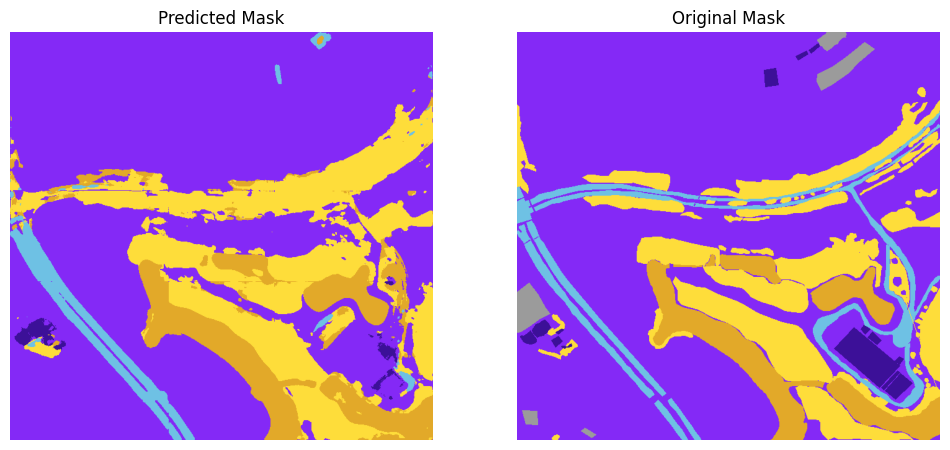

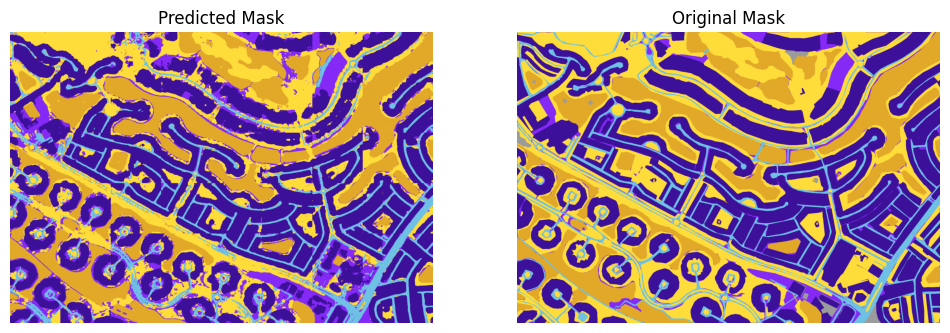

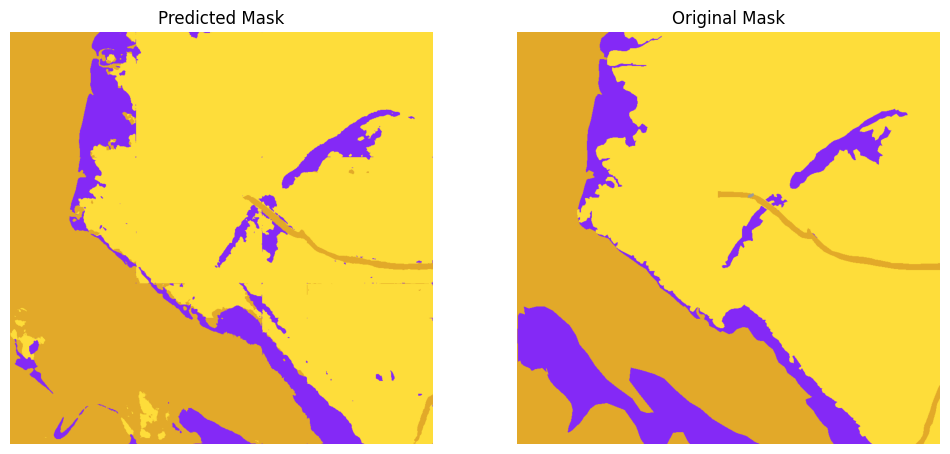

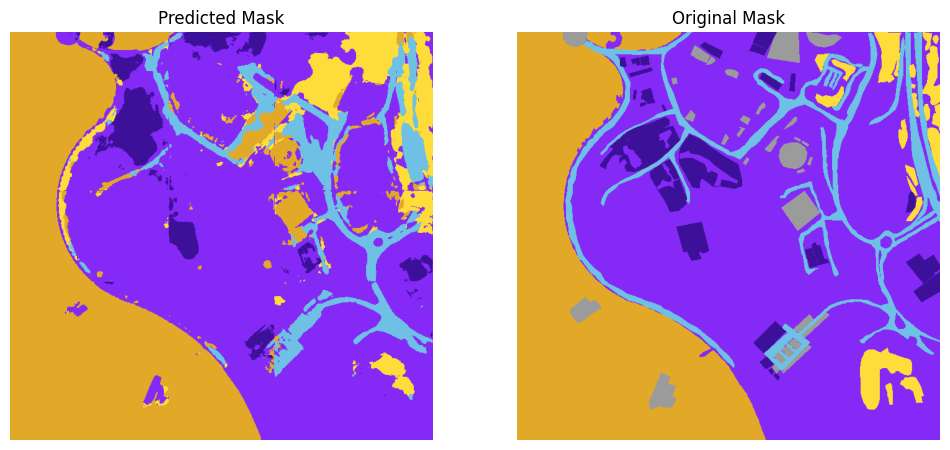

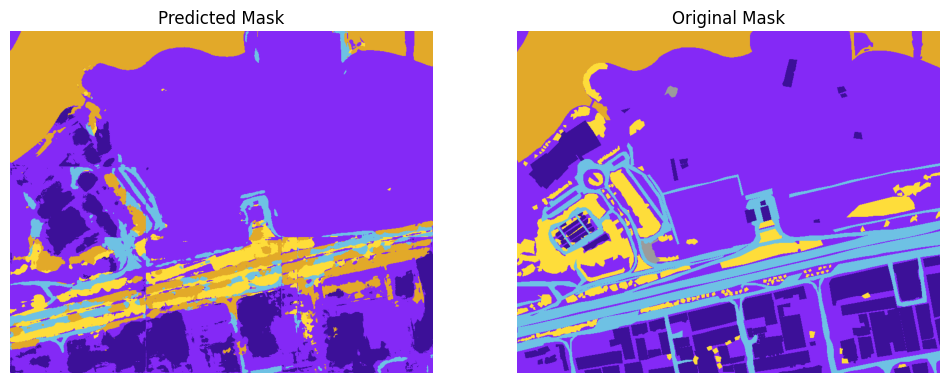

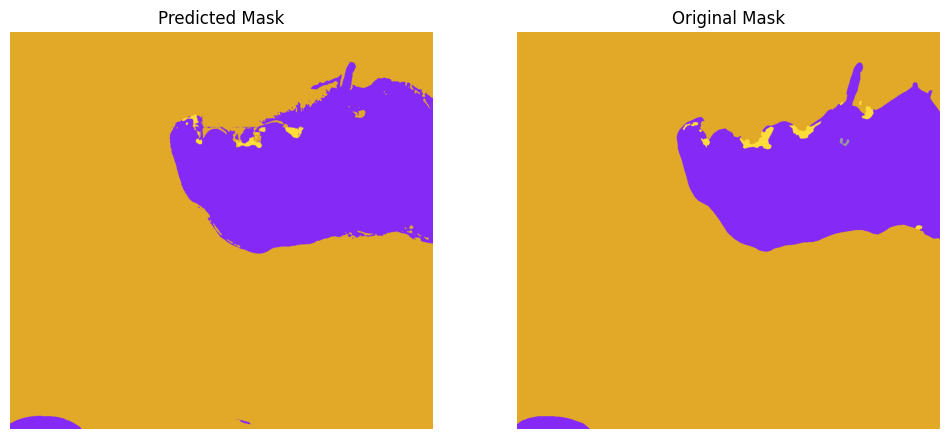

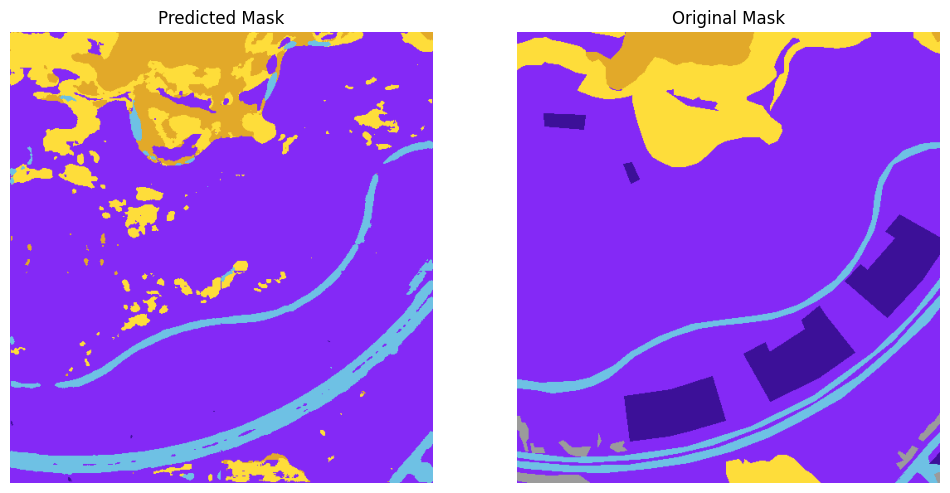

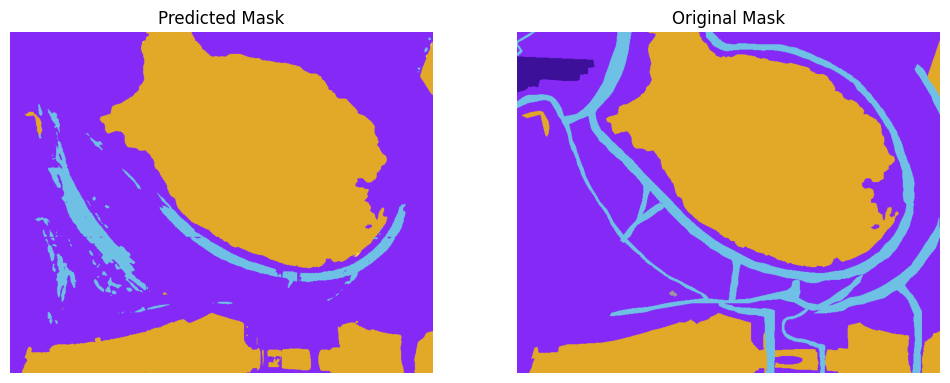

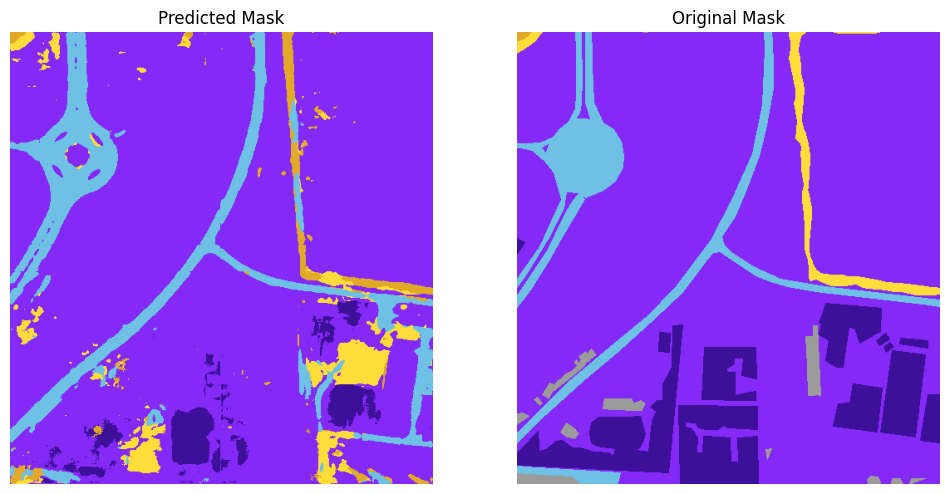

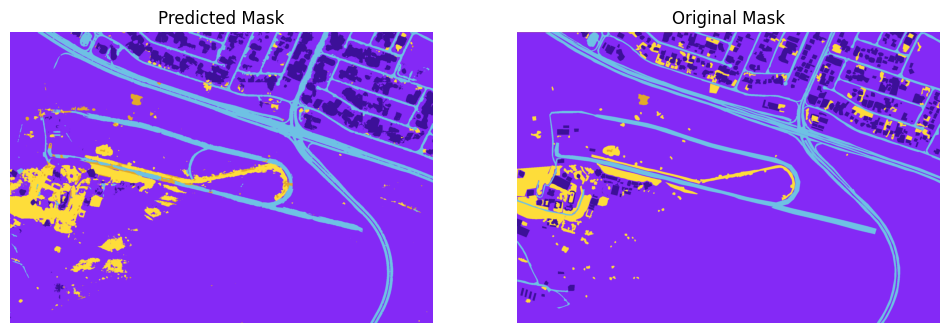

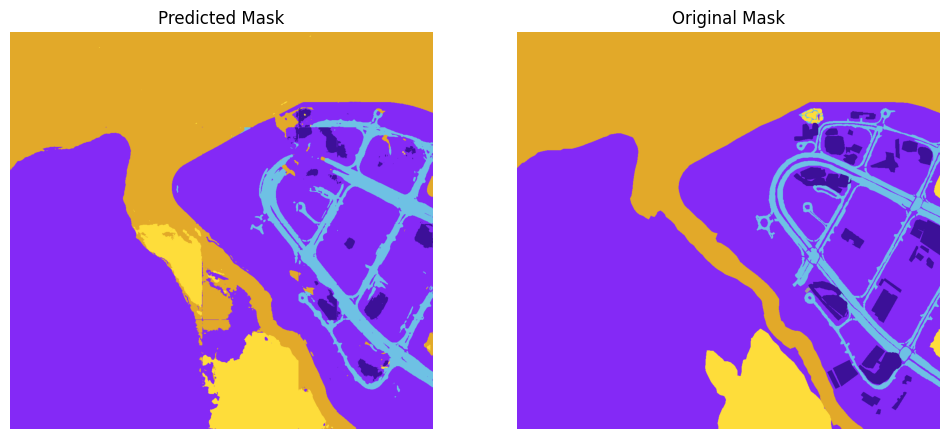

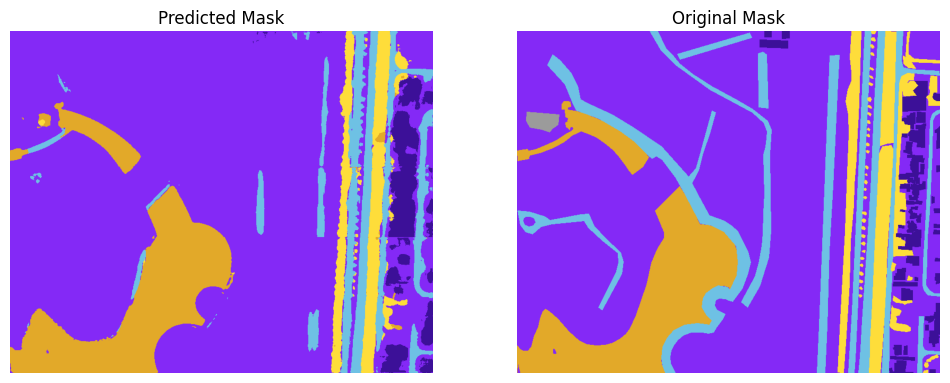

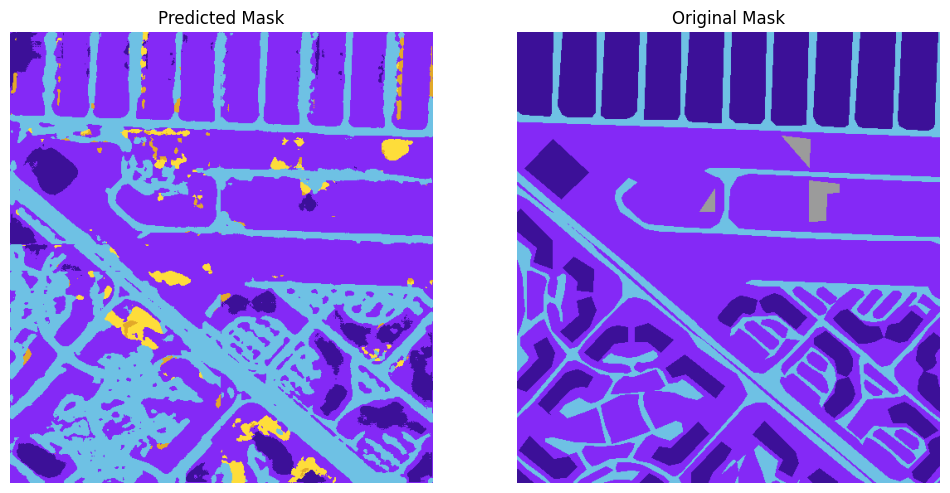

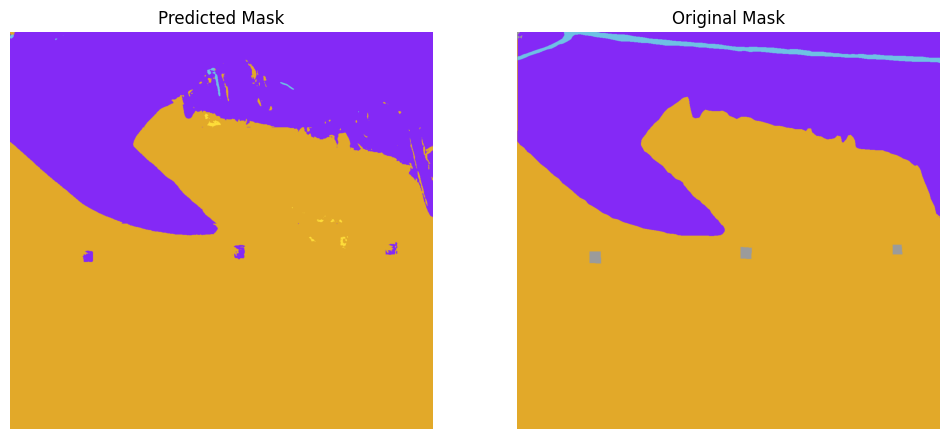

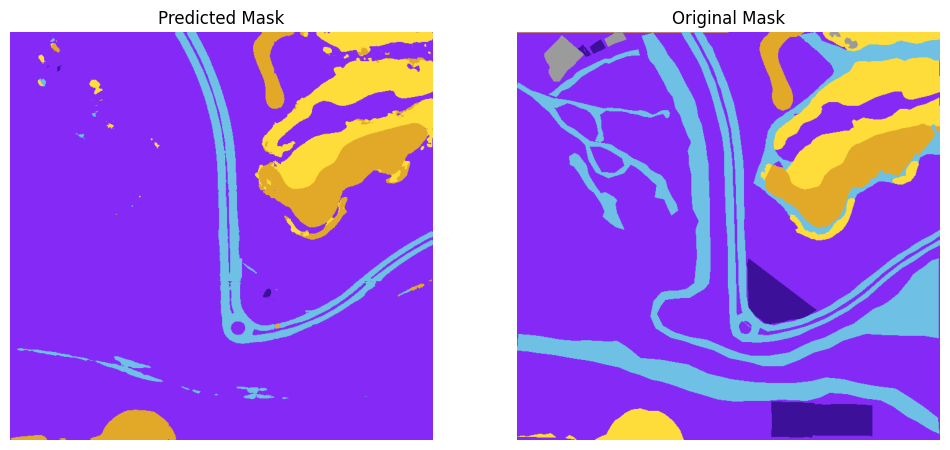

In [ ]:
for _file_path in test_df["mask_path"].unique():
    _img_shape = cv2.imread(_file_path).shape
    coords = []
    for _, row in test_df[test_df["mask_path"] == _file_path].iterrows():
        coords.append(row.loc[["img_path", "xmin", "xmax", "ymin", "ymax"]].to_dict())

    strt_idx = test_df[test_df["mask_path"] == _file_path].index.to_list()[0]
    end_idx = test_df[test_df["mask_path"] == _file_path].index.to_list()[-1] + 1

    predicted_unpatched_mask = unpatch(
        patchs=predicted_mask_decoded[strt_idx:end_idx],
        patch_coord=coords,
        img_shape=_img_shape,
    )

    true_unpatched_mask = unpatch(
        patchs=true_mask_decoded[strt_idx:end_idx],
        patch_coord=coords,
        img_shape=_img_shape,
    )

    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.imshow(predicted_unpatched_mask)
    plt.axis("off")
    plt.title("Predicted Mask")

    plt.subplot(122)
    plt.imshow(true_unpatched_mask)
    plt.axis("off")
    plt.title("Original Mask")